cette section concerne la modelisation du RAC par le modele GAM

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Dictionnaires nécessaires</b></h2>

In [79]:
region_mapping = {
    5: "Régions et Départements d'outre-mer",
    11: "Ile-de-France",
    24: "Centre-Val-de-Loire",
    27: "Bourgogne-Franche-Comté",
    28: "Normandie",
    32: "Hauts-de-France",
    44: "Grand Est",
    52: "Pays de la Loire",
    53: "Bretagne",
    75: "Nouvelle-Aquitaine",
    76: "Occitanie",
    84: "Auvergne-Rhône-Alpes",
    93: "Provence-Alpes-Côte d'Azur et Corse"
}

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Importation des librairies nécessaires</b></h2>

In [80]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, norm, gamma, skewnorm
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.simplefilter('ignore', category=UserWarning)
 


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Chargement des données et leurs visualisations</b></h2>

In [81]:
df = pd.read_csv("/raid/home/allianzsante/farchakhi_dou/RAC_nouveau.csv")

Aperçu des données

In [82]:
df.head()

,FLX_ANN_MOI,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT
0,201901.0,2.0,70.0,5.0,4175537.69,2.538271e+07,2.120717e+07
1,201901.0,2.0,80.0,24.0,7357488.44,3.480094e+07,2.744345e+07
2,201901.0,1.0,0.0,52.0,9717960.12,2.445639e+07,1.473843e+07
3,201901.0,2.0,60.0,5.0,5179146.18,2.548382e+07,2.030468e+07
4,201901.0,1.0,40.0,52.0,6926479.09,2.127533e+07,1.434885e+07


Changement de types et extraction des mois et de l'année

In [83]:
df = df.astype({
    'FLX_ANN_MOI': 'str',
    'AGE_BEN_SNDS': 'int32',
    'BEN_SEX_COD': 'int32',
    'BEN_RES_REG': 'int32'
})
df['annee'] = df['FLX_ANN_MOI'].str[: 4].astype('int32')
df['mois'] = df['FLX_ANN_MOI'].str[4: 6].astype('int32')
df.drop(columns=['FLX_ANN_MOI'], inplace=True)
df.head()

,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT,annee,mois
0,2,70,5,4175537.69,2.538271e+07,2.120717e+07,2019,1
1,2,80,24,7357488.44,3.480094e+07,2.744345e+07,2019,1
2,1,0,52,9717960.12,2.445639e+07,1.473843e+07,2019,1
3,2,60,5,5179146.18,2.548382e+07,2.030468e+07,2019,1
4,1,40,52,6926479.09,2.127533e+07,1.434885e+07,2019,1


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Filtrage des données</b></h2>

On enlève les valeurs inconnues pour le sexe et l'âge et on ne garde que les données agrégés mensuellement

In [84]:

df.rename(columns = {'AGE_BEN_SNDS': 'age', 'BEN_RES_REG': 'region', 'BEN_SEX_COD': 'sexe', 'FLT_PAI_MNT': 'PAI', 'FLT_REM_MNT': 'REM'}, inplace = True)

df['region'] = df['region'].map(region_mapping)

df_grouped = df.drop(columns = ['PAI', 'REM', 'age', 'sexe']).groupby(by = ['annee', 'mois',  'region']).sum()

df_grouped.reset_index(inplace=True)

df_grouped


,annee,mois,region,RAC
0,2019,1,Auvergne-Rhône-Alpes,3.258587e+08
1,2019,1,Bourgogne-Franche-Comté,1.011125e+08
2,2019,1,Bretagne,1.138065e+08
3,2019,1,Centre-Val-de-Loire,9.193878e+07
4,2019,1,Grand Est,2.519127e+08
...,...,...,...,...
931,2024,12,Nouvelle-Aquitaine,2.964126e+08
932,2024,12,Occitanie,2.937130e+08
933,2024,12,Pays de la Loire,1.683764e+08
934,2024,12,Provence-Alpes-Côte d'Azur et Corse,3.012519e+08


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création d'un champ population</b></h2>

Importation des données démographiques 

In [85]:
years = np.append(np.array([2018]), df_grouped['annee'].unique())
year_population_dataframes = {}
for year in years:
    print(f"Dataframe crée pour l'année {year}")
    df_year = pd.read_csv(f"/raid/home/allianzsante/farchakhi_dou/CSV demographie/population par région fin {year}.csv", sep=';', decimal = ' ', encoding= "latin")
    df_year = pd.melt(df_year, value_vars=['Hommes','Femmes'], value_name="population", var_name="sexe", id_vars="Région")
    df_year['annee'] = year     
    df_year.rename(columns={'Région': 'region'}, inplace=True)
    df_year.drop(columns= ['sexe'], inplace=True)
    df_year['population'] = df_year['population'].str.replace(' ','')
    df_year['population'] = df_year['population'].astype(float)
    df_year = df_year.groupby(by = ['annee', 'region']).sum().reset_index()
    year_population_dataframes[year] = df_year

year_population_dataframes[2018]

Dataframe crée pour l'année 2018
Dataframe crée pour l'année 2019
Dataframe crée pour l'année 2020
Dataframe crée pour l'année 2021
Dataframe crée pour l'année 2022
Dataframe crée pour l'année 2023
Dataframe crée pour l'année 2024


,annee,region,population
0,2018,Auvergne-Rhône-Alpes,8042936.0
1,2018,Bourgogne-Franche-Comté,2805580.0
2,2018,Bretagne,3354854.0
3,2018,Centre-Val-de-Loire,2573180.0
4,2018,Grand Est,5556219.0
5,2018,Hauts-de-France,6004947.0
6,2018,Ile-de-France,12262544.0
7,2018,Normandie,3325032.0
8,2018,Nouvelle-Aquitaine,6010289.0
9,2018,Occitanie,5933185.0


Interpolation mensuelle des données démographiques par région

In [86]:
def interpolate_population(data_1, data_2):
    # Copier les données des deux années pour éviter de modifier les originaux
    df_year_1 = data_1.copy()
    df_year_2 = data_2.copy()
    
    # Calculer la différence annuelle de population et la diviser par 12 pour obtenir les incréments mensuels
    difference_yearly_pop = ((df_year_2['population'] - df_year_1['population']) / 12).to_list()
    
    # Créer une liste des populations interpolées mensuellement
    df_year_2['monthly_population'] = [
        [df_year_1['population'].iloc[i] + j * difference_yearly_pop[i] for j in range(1, 13)]
        for i in range(len(df_year_1))
    ]
    df_year_2['mois'] = list(range(1, 13) for _ in range(len(df_year_1))) 
    
    # Transformer les listes en lignes individuelles
    df_year_2 = df_year_2.explode(['monthly_population', 'mois']).reset_index(drop=True)

    # Supprimer la colonne 'population' car elle n'est plus nécessaire
    df_year_2.drop(columns=['population'], inplace=True)

    # Trier les données par année et mois
    df_year_2.sort_values(by=['annee', 'mois'])

    return df_year_2

# Interpoler les données pour toutes les années disponibles
def interpolate_all_data(data):
    all_data = {}
    for year in sorted(data.keys())[:-1]: 
        # Récupérer les données de deux années consécutives
        data_1 = year_population_dataframes[year]
        data_2 = year_population_dataframes[year + 1]
        # Interpoler les données entre ces deux années
        all_data[year + 1] = interpolate_population(data_1, data_2)
    
    # Combiner toutes les données interpolées en un seul DataFrame
    return pd.concat(all_data.values())

# Appliquer l'interpolation à toutes les données démographiques
all_data = interpolate_all_data(year_population_dataframes)
all_data


,annee,region,monthly_population,mois
0,2019,Auvergne-Rhône-Alpes,8045912.333333,1
1,2019,Auvergne-Rhône-Alpes,8048888.666667,2
2,2019,Auvergne-Rhône-Alpes,8051865.0,3
3,2019,Auvergne-Rhône-Alpes,8054841.333333,4
4,2019,Auvergne-Rhône-Alpes,8057817.666667,5
...,...,...,...,...
151,2024,Régions et Départements d'outre-mer,2250323.666667,8
152,2024,Régions et Départements d'outre-mer,2251157.0,9
153,2024,Régions et Départements d'outre-mer,2251990.333333,10
154,2024,Régions et Départements d'outre-mer,2252823.666667,11


Fusion des données de l'Open Damir avec les données démographiques

In [87]:
# on va merge les dataframes

copied_df = df_grouped.copy()

# Merge les dataframes sur 'annee', 'age', et 'sexe'.
final_df = copied_df.merge(all_data, how = 'right', on= ['annee', 'mois', 'region'], suffixes=('', '_new'))

final_df['monthly_population'] = final_df['monthly_population'].astype(float)

final_df['RAC'] = final_df['RAC'].astype(float)

final_df['mois'] = final_df['mois'].astype(int)

final_df['RAC_par_personne'] = final_df['RAC'] / final_df['monthly_population'] 

final_df.shape


(936, 6)

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création de la base de données</b></h2>

In [88]:
def get_all_data_beginning_from_year(current_year, ending_year= 2024): 
    return final_df[(ending_year >= final_df['annee']) & (final_df['annee'] >= current_year)].sort_values(by=['annee', 'mois', 'region'])
get_all_data_beginning_from_year(2021).head()

,annee,mois,region,RAC,monthly_population,RAC_par_personne
312,2021,1,Auvergne-Rhône-Alpes,3.064495e+08,8.118488e+06,37.747116
324,2021,1,Bourgogne-Franche-Comté,9.252446e+07,2.800509e+06,33.038442
336,2021,1,Bretagne,1.097871e+08,3.396924e+06,32.319556
348,2021,1,Centre-Val-de-Loire,8.471779e+07,2.573994e+06,32.912969
360,2021,1,Grand Est,2.240149e+08,5.561186e+06,40.281855


Choix de la loi de distribution

In [112]:
from pygam import LinearGAM, GammaGAM, PoissonGAM, s, f
import pandas as pd

# Suppose que X et y sont déjà définis
models = {
    "Normal": LinearGAM(s(0) + s(1) + f(2)),
    "Gamma": GammaGAM(s(0) + s(1) + f(2)),
    "Poisson": PoissonGAM(s(0) + s(1) + f(2))
}

results = []

for name, model in models.items():
    model.gridsearch(X, y)
    stats = model.statistics_
    results.append({
        "Modèle": name,
        "R2": round(stats['pseudo_r2']['explained_deviance'], 4) if stats['pseudo_r2']['explained_deviance'] is not None else None,
        "AIC": round(stats['AIC'], 2) if stats['AIC'] is not None else None,
        "GCV": round(stats['GCV'], 4) if stats['GCV'] is not None else None,
        "Log-likelihood": round(stats['loglikelihood'], 2) if stats['loglikelihood'] is not None else None,
         
    })

df_results = pd.DataFrame(results).sort_values(by="AIC")
print(df_results)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


    Modèle      R2      AIC     GCV  Log-likelihood
1    Gamma  0.9458  1260.46  0.0023         -604.40
0   Normal  0.9400  1439.55  3.7227         -693.95
2  Poisson  0.9354  1792.46     NaN         -874.01


Implementation du modele gam

In [113]:
 
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def GAM_model(year, ending_year=2024):
    df_GAM = get_all_data_beginning_from_year(year, ending_year)

    # Encodage numérique de la région (nécessaire pour pygam)
    le = LabelEncoder()
    df_GAM['region_encoded'] = le.fit_transform(df_GAM['region'])

    # Définir les features
    X = df_GAM[['annee', 'mois', 'region_encoded']].astype(float).values
    y = df_GAM['RAC_par_personne'].astype(float).values

    # Modèle GAM avec s(annee) + s(mois) + f(region)
    gam =GammaGAM(s(0) + s(1) + f(2))
    gam_results = gam.fit(X , y)
     
    return gam ,  gam_results 


ENTRAINEMENT 2021-2023

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


GammaGAM                                                                                                  
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     24.8234
Link Function:                          LogLink Log Likelihood:                                  -604.4044
Number of Samples:                          312 AIC:                                             1260.4557
                                                AICc:                                            1265.3135
                                                GCV:                                                0.0023
                                                Scale:                                               0.002
                                                Pseudo R-Squared:                                   0.9458
Feature Function                  Lam

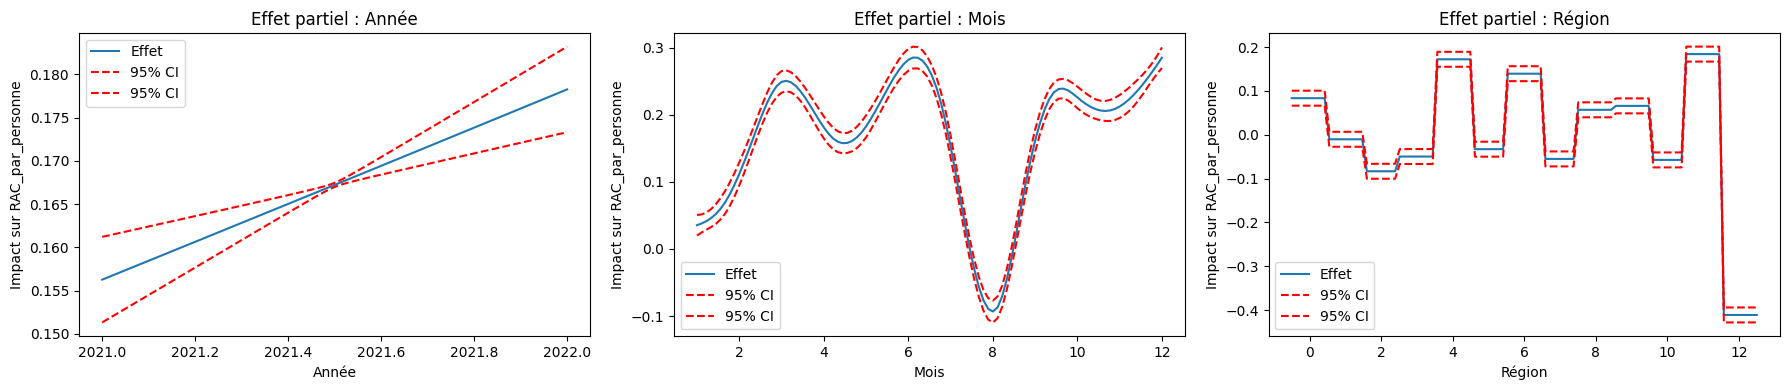

In [ ]:
 
import scipy.sparse

def to_array(self):
    return self.toarray()

scipy.sparse.spmatrix.A = property(to_array)

 

# Chargement et préparation des données
df = get_all_data_beginning_from_year(2021, 2022).copy()

# Encodage de la région
le = LabelEncoder()
df['region_encoded'] = le.fit_transform(df['region'])

# Préparation des features et de la cible
X = df[['annee', 'mois', 'region_encoded']].astype(float).values
y = df['RAC_par_personne'].astype(float).values

# Supprimer les lignes où y est NaN ou Inf
mask = (~np.isnan(y)) & (~np.isinf(y))
X_clean = X[mask]
y_clean = y[mask]

# Définir et optimiser le modèle avec gridsearch (meilleur lissage)
gam = GammaGAM(s(0) + s(1) + f(2))
gam.gridsearch(X_clean, y_clean)

# Résumé du modèle
gam.summary()

# Visualisation des effets partiels
titles = ['Année', 'Mois', 'Région']
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), label='Effet')
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--', label='95% CI')
    ax.set_title(f"Effet partiel : {titles[i]}")
    ax.set_xlabel(titles[i])
    ax.set_ylabel("Impact sur RAC_par_personne")
    ax.legend()

plt.tight_layout()
plt.show()


In [92]:
gam.coef_

array([ 0.15498537,  0.15627169,  0.15755803,  0.15884466,  0.16013182,
        0.16141977,  0.16270869,  0.16399875,  0.16529007,  0.16658272,
        0.16787676,  0.16917218,  0.17046894,  0.17176698,  0.17306617,
        0.17436636,  0.17566735,  0.1769689 ,  0.17827074,  0.17957259,
        0.02636643,  0.03301934,  0.05411852,  0.15672099,  0.27347487,
        0.22879765,  0.14850048,  0.16115394,  0.24465174,  0.30803452,
        0.2382606 , -0.02944613, -0.15053491,  0.11296194,  0.26386548,
        0.2190485 ,  0.19763133,  0.22637063,  0.28447326,  0.3475194 ,
        0.08328216, -0.01047043, -0.08344562, -0.04984409,  0.17199429,
       -0.03303885,  0.13917553, -0.05524353,  0.05675171,  0.06572851,
       -0.05753637,  0.18382925, -0.41118176,  3.34498855])

In [93]:
print([str(t) for t in gam.terms])

['spline_term', 'spline_term', 'factor_term', 'intercept_term']


Validation du modele 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Charger les données de test
df_test = get_all_data_beginning_from_year(2024).copy()

# Encoder la région comme à l'entraînement (utiliser transform, pas fit_transform)
df_test['region_encoded'] = le.transform(df_test['region'])

# Préparer les features de test (mêmes colonnes que X_train)
X_test = df_test[['annee', 'mois', 'region_encoded']].astype(float).values

# Préparer la cible réelle
y_test = df_test['RAC_par_personne'].astype(float).values

# Prédiction avec le modèle GAM
gam_predictions = gam.predict(X_test)

# Création d’un DataFrame pour comparer vraies et prédites
Results_df = df_test[['annee', 'mois', 'region']].copy()
Results_df['true_values'] = y_test
Results_df['predicted_values'] = gam_predictions

 

Methode Z-score

In [118]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Récupérer les statistiques du modèle
stats = gam.statistics_
coefs = gam.coef_
cov_matrix = stats['cov']
le = LabelEncoder()
le.fit(df_test['region'])  # Assure-toi que le LabelEncoder est bien entraîné comme dans ton modèle

# Indices des coefficients de la variable catégorielle région (f(2))
region_term_index = 2
region_indices = gam.terms.get_coef_indices(region_term_index)
region_coefs = coefs[region_indices]

# Erreurs standards et z-scores
std_errors = np.sqrt(np.diag(cov_matrix))[region_indices]
z_scores = region_coefs / std_errors

# Nom des régions hors baseline
# Correction: use all classes if lengths match, otherwise skip baseline
if len(region_coefs) == len(le.classes_):
    region_names = le.classes_
else:
    region_names = le.classes_[1:]

# Créer un DataFrame résumé
df_test = pd.DataFrame({
    'Région': region_names,
    'Coefficient': region_coefs,
    'Erreur standard': std_errors,
    'z-score': z_scores
})

# Afficher le tableau trié par |z|
df_wald = df_test.sort_values(by='z-score', ascending=False)
print(df_wald)


                                 Région  Coefficient  Erreur standard  \
11  Provence-Alpes-Côte d'Azur et Corse     0.183829         0.008671   
4                             Grand Est     0.171994         0.008671   
6                         Ile-de-France     0.139176         0.008671   
0                  Auvergne-Rhône-Alpes     0.083282         0.008671   
9                             Occitanie     0.065729         0.008671   
8                    Nouvelle-Aquitaine     0.056752         0.008671   
1               Bourgogne-Franche-Comté    -0.010470         0.008671   
5                       Hauts-de-France    -0.033039         0.008671   
3                   Centre-Val-de-Loire    -0.049844         0.008671   
7                             Normandie    -0.055244         0.008671   
10                     Pays de la Loire    -0.057536         0.008671   
2                              Bretagne    -0.083446         0.008671   
12  Régions et Départements d'outre-mer    -0.41118

Analyse des residus et MAPE

In [121]:
residus_gam = y_test - gam.predict(X_test)
print("Les résidus sont égaux à :", np.mean(residus_gam))
# Calcul de l'erreur absolue moyenne en pourcentage (MAPE)
mape_gam = mean_absolute_percentage_error(y_test, gam_predictions)
print(f"La MAPE pour le modèle GAM pour la prédiction du RAC : {mape_gam * 100:.2f}%")
 

Les résidus sont égaux à : 1.5005872966417577
La MAPE pour le modèle GAM pour la prédiction du RAC : 6.03%


Prediction pour les donnees 2025 

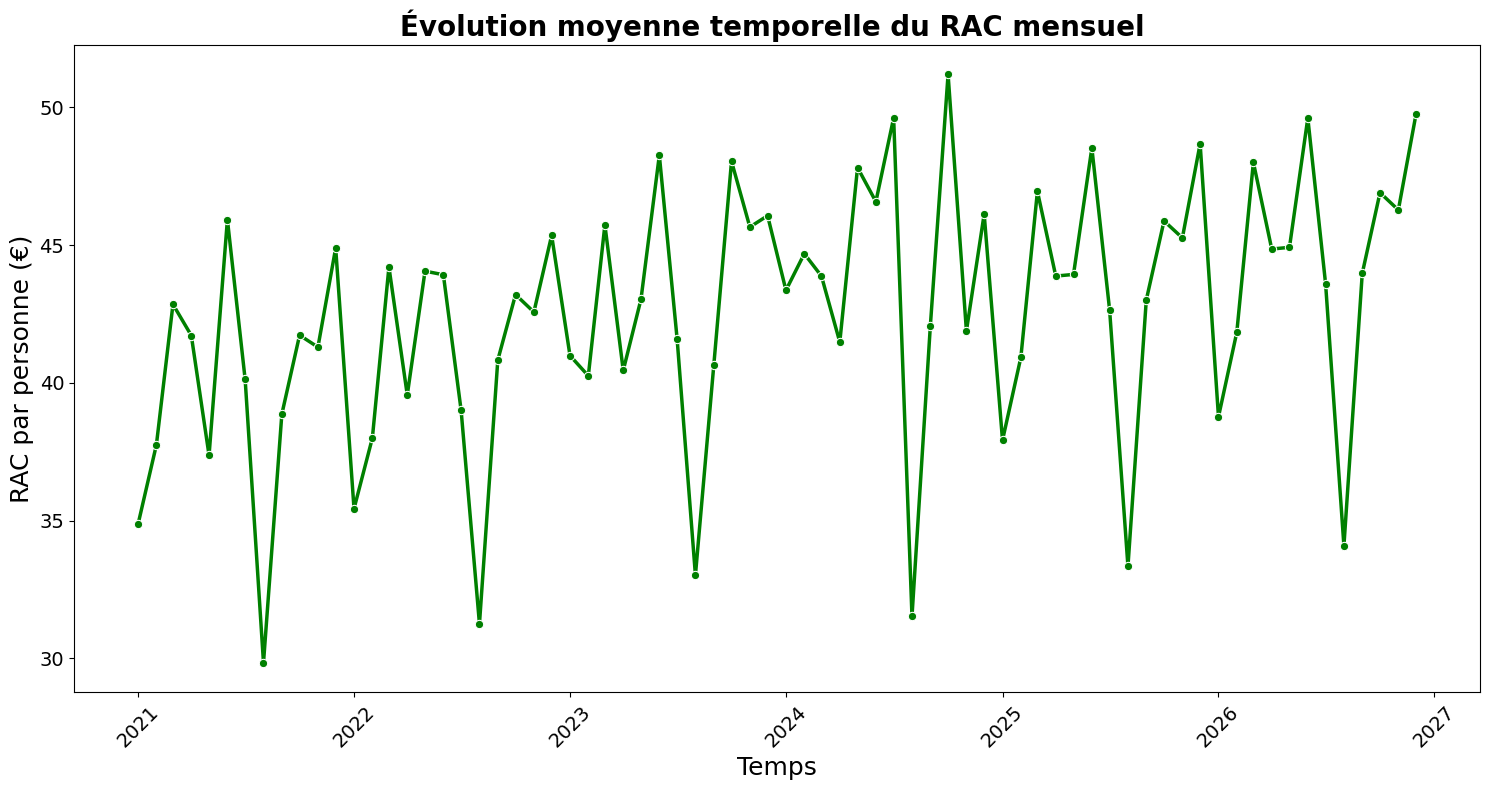

In [ ]:
 

# Charger la base historique (2021–2023)
data_prior_to_2024 = get_all_data_beginning_from_year(2021).copy()
data_prior_to_2024 = data_prior_to_2024.groupby(['annee', 'mois']).mean(numeric_only=True).reset_index()

# --- PRÉPARATION DES DONNÉES FUTURES ---
def prepare_future_gam_data(base_year, future_year):
    df = get_all_data_beginning_from_year(base_year).copy()
    df['region_encoded'] = le.fit_transform(df['region'])  # utiliser le même encodage
    df = df[['annee', 'mois', 'region_encoded']].astype(float)
    df['annee'] = future_year
    return df.values

# Préparer les données d'entrée pour 2025 et 2026 (structure de 2024, annee modifiée)
X_2025 = prepare_future_gam_data(2024, 2025)
X_2026 = prepare_future_gam_data(2024, 2026)

# Prédictions GAM
predictions_2025 = gam.predict(X_2025)
predictions_2026 = gam.predict(X_2026)

# Convertir en DataFrames
df_2025 = pd.DataFrame(X_2025, columns=['annee', 'mois', 'region_encoded'])
df_2025['RAC_par_personne'] = predictions_2025

df_2026 = pd.DataFrame(X_2026, columns=['annee', 'mois', 'region_encoded'])
df_2026['RAC_par_personne'] = predictions_2026

# Agréger par mois pour une courbe globale
df_2025_agg = df_2025.groupby(['annee', 'mois']).mean(numeric_only=True).reset_index()
df_2026_agg = df_2026.groupby(['annee', 'mois']).mean(numeric_only=True).reset_index()

# Fusion avec données historiques
all_temporal_data = pd.concat([data_prior_to_2024, df_2025_agg, df_2026_agg], ignore_index=True)


# Ajouter une colonne "time" pour la courbe temporelle
all_temporal_data['time'] = pd.to_datetime(
    all_temporal_data['annee'].astype(int).astype(str) + '-' + all_temporal_data['mois'].astype(int).astype(str),
    format='%Y-%m'
)

# --- VISUALISATION ---
plt.figure(figsize=(15, 8))
sns.lineplot(data=all_temporal_data, x='time', y='RAC_par_personne', marker='o', linewidth=2.5, color='green')

plt.title("Évolution moyenne temporelle du RAC mensuel ", fontsize=20, fontweight='bold')
plt.xlabel("Temps", fontsize=18)
plt.ylabel("RAC par personne (€)", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


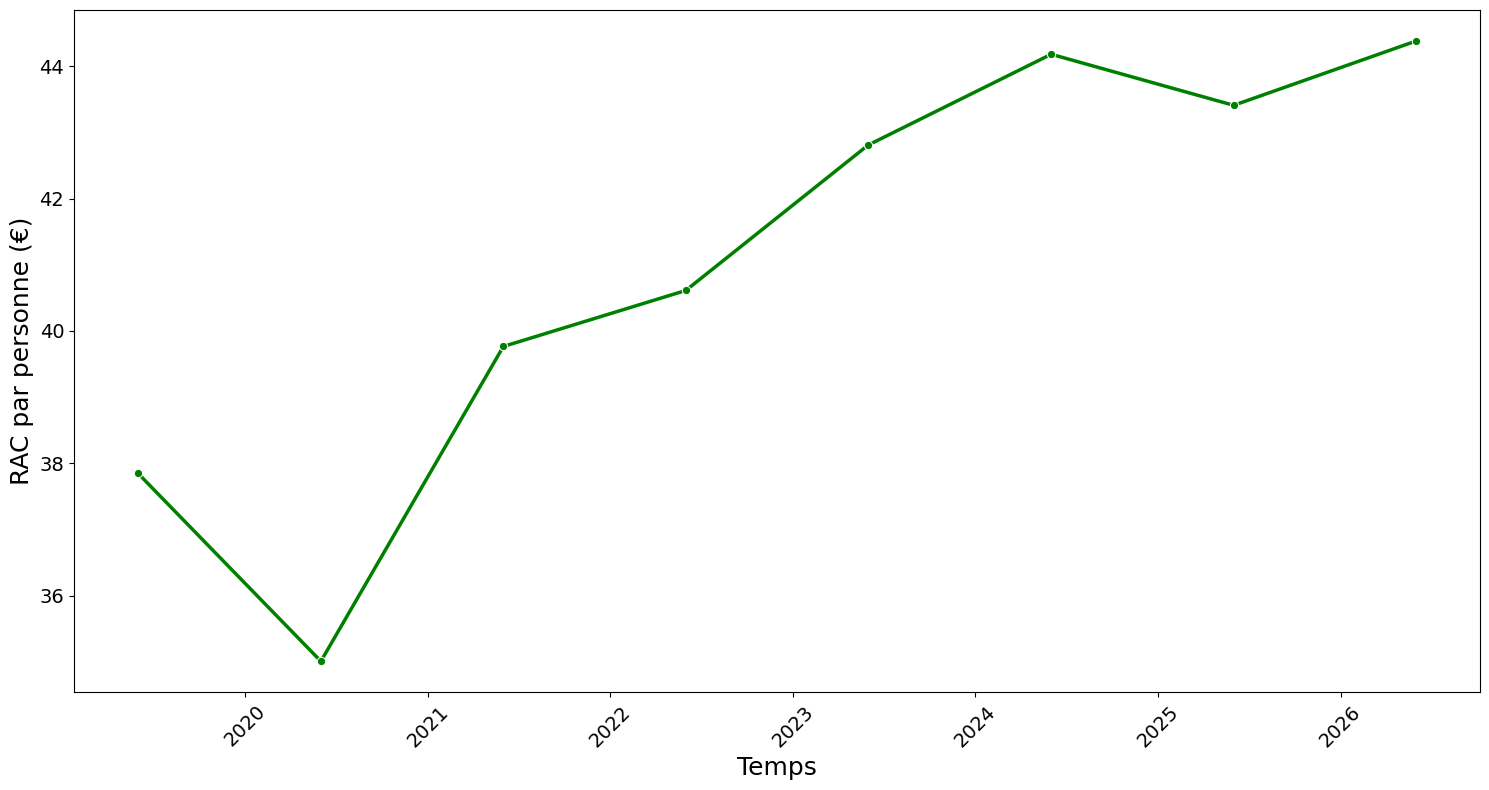

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Charger la base historique (2019–2023)
data_prior_to_2024 = get_all_data_beginning_from_year(2019).copy()
data_prior_to_2024 = data_prior_to_2024.groupby(['annee' ]).mean(numeric_only=True).reset_index()

# --- PRÉPARATION DES DONNÉES FUTURES ---
def prepare_future_gam_data(base_year, future_year):
    df = get_all_data_beginning_from_year(base_year).copy()
    df['region_encoded'] = le.fit_transform(df['region'])  # utiliser le même encodage
    df = df[['annee', 'mois', 'region_encoded']].astype(float)
    df['annee'] = future_year
    return df.values

# Préparer les données d'entrée pour 2025 et 2026 (structure de 2024, annee modifiée)
X_2025 = prepare_future_gam_data(2024, 2025)
X_2026 = prepare_future_gam_data(2024, 2026)

# Prédictions GAM
predictions_2025 = gam.predict(X_2025)
predictions_2026 = gam.predict(X_2026)

# Convertir en DataFrames
df_2025 = pd.DataFrame(X_2025, columns=['annee', 'mois', 'region_encoded'])
df_2025['RAC_par_personne'] = predictions_2025

df_2026 = pd.DataFrame(X_2026, columns=['annee','mois',   'region_encoded'])
df_2026['RAC_par_personne'] = predictions_2026

# Agréger par mois pour une courbe globale
df_2025_agg = df_2025.groupby(['annee' ]).mean(numeric_only=True).reset_index()
df_2026_agg = df_2026.groupby(['annee' ]).mean(numeric_only=True).reset_index()

# Fusion avec données historiques
all_temporal_data = pd.concat([data_prior_to_2024, df_2025_agg, df_2026_agg], ignore_index=True)

# Ajouter une colonne "time" pour la courbe temporelle
all_temporal_data['time'] = pd.to_datetime(
    all_temporal_data['annee'].astype(int).astype(str) + '-' + all_temporal_data['mois'].astype(int).astype(str),
    format='%Y-%m'
)

# --- VISUALISATION ---
plt.figure(figsize=(15, 8))
sns.lineplot(data=all_temporal_data, x='time', y='RAC_par_personne', marker='o', linewidth=2.5, color='green')

#plt.title("Évolution temporelle du RAC par personne (GAM)", fontsize=20, fontweight='bold')
plt.xlabel("Temps", fontsize=18)
plt.ylabel("RAC par personne (€)", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()
